In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
from torchvision.models import resnet50
import torchaudio.transforms as T
from tqdm import tqdm

In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

In [3]:
device = torch.device('cuda:0')
data_dir = '../input/gtzan-dataset-music-genre-classification/Data/genres_original'

In [4]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [5]:
NUM_SAMPLES = 660000
sr = 22050
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
train_size = 0.8

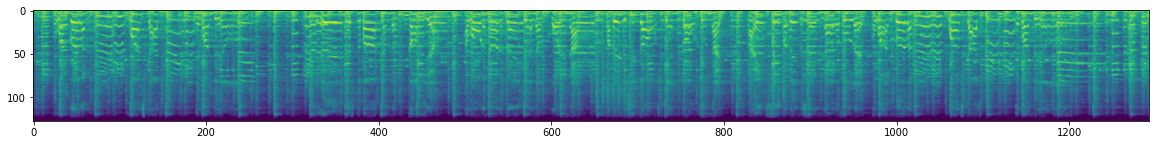

In [6]:
y, _ = librosa.load('../input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00000.wav', sr = sr)
begin = (len(y) - NUM_SAMPLES) // 2
samples = y[begin:begin + NUM_SAMPLES]
samples = y
melspec = librosa.feature.melspectrogram(y=samples, sr=sr, n_mels = nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [7]:
melspec.shape

(128, 1293)

In [8]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 55):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def TimeCycleShift(image, max_shift = 55):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def TimeSwapAugmentation(image, max_b = 258):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def TimeReplyMasking(image, max_b = 55):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 258):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(55)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(55)(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)   
    
    return image

In [9]:
def get_spectrogram(filename, sr = 22050):
    y, _ = librosa.load(filename, sr = sr)
    begin = (len(y) - NUM_SAMPLES) // 2
    samples = y[begin:begin + NUM_SAMPLES]
    melspec = librosa.feature.melspectrogram(y=samples, sr=sr, n_mels = nmels, fmin=fmin, fmax=fmax)
    melspec = librosa.power_to_db(melspec)
    melspec = normalize(melspec, mean=None, std=None)

    return torch.tensor(melspec, dtype=torch.float32)

In [10]:
class GTZAN(Dataset):
    def __init__(self, keys, data = [], labels = []):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [11]:
data = []
labels = []
class_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
for j in tqdm(range(10)):
    label = j
    music_dir = data_dir + '/' + class_names[j]
    music_files = sorted(os.listdir(music_dir))
    for i in range(len(music_files)):
        filename =  music_dir + '/' + music_files[i]
        if 'jazz.00054.wav' not in filename:
            data.append(get_spectrogram(filename))
            labels.append(label)

100%|██████████| 10/10 [01:33<00:00,  9.36s/it]


In [12]:
len(labels)

999

In [13]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, use_augmentation = False, aug_type = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    
    for epoch in tqdm(range(epochs)):
        #Train
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            if use_augmentation:
                for i in range(len(y)):
                    if np.random.rand() < 0.5:
                        X[i] = augmentation(X[i], mode = aug_type)
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)
        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        
        #Validation
        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())

    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, [train_losses, valid_losses, valid_acc]

In [14]:
def evaluate(model, test_loader):
    model.eval()
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)

    mean_accuracy = sum_accuracy / cnt_objects
    print('************************')
    print('Quality of the model')
    print('Accuracy on test:', mean_accuracy)
    return mean_accuracy

In [15]:
no_augmentation_accuracy50 = []
time_swap_augmentation_accuracy50 = []

# Random seed = 1

In [16]:
random_seed = 1

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = GTZAN(data = data, labels = labels, keys = train_keys)
valid_dataset = GTZAN(data = data, labels = labels, keys = valid_keys)
test_dataset = GTZAN(data = data, labels = labels, keys = test_keys)

## Resnet50

#### No augmentation

setting everything to seed 1


100%|██████████| 100/100 [28:50<00:00, 17.31s/it]


Accuracy on the validation:  0.78125
************************
Quality of the model
Accuracy on test: 0.685


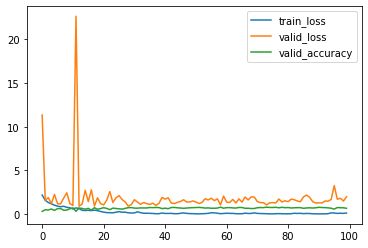

In [17]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

setting everything to seed 1


100%|██████████| 100/100 [29:05<00:00, 17.45s/it]


Accuracy on the validation:  0.8
************************
Quality of the model
Accuracy on test: 0.645


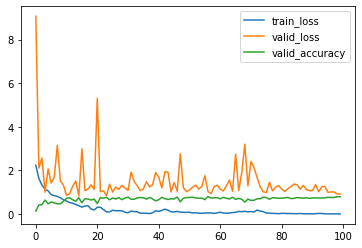

In [18]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random_seed = 42

In [19]:
random_seed = 42

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = GTZAN(data = data, labels = labels, keys = train_keys)
valid_dataset = GTZAN(data = data, labels = labels, keys = valid_keys)
test_dataset = GTZAN(data = data, labels = labels, keys = test_keys)

## Resnet50

#### No augmentation

setting everything to seed 42


100%|██████████| 100/100 [28:44<00:00, 17.24s/it]


Accuracy on the validation:  0.73125
************************
Quality of the model
Accuracy on test: 0.74


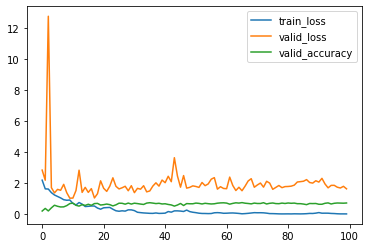

In [20]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

setting everything to seed 42


100%|██████████| 100/100 [29:05<00:00, 17.46s/it]


Accuracy on the validation:  0.78125
************************
Quality of the model
Accuracy on test: 0.68


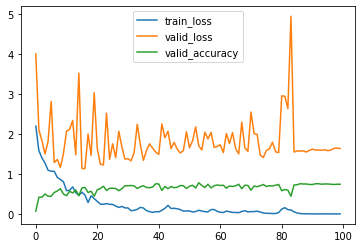

In [21]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random_seed = 10

In [22]:
random_seed = 10

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = GTZAN(data = data, labels = labels, keys = train_keys)
valid_dataset = GTZAN(data = data, labels = labels, keys = valid_keys)
test_dataset = GTZAN(data = data, labels = labels, keys = test_keys)

## Resnet50

#### No augmentation

setting everything to seed 10


100%|██████████| 100/100 [28:44<00:00, 17.25s/it]


Accuracy on the validation:  0.7875
************************
Quality of the model
Accuracy on test: 0.77


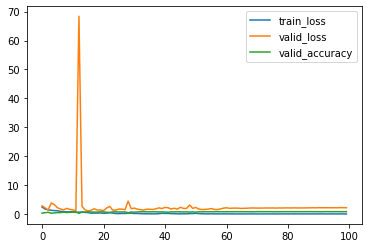

In [23]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

setting everything to seed 10


100%|██████████| 100/100 [29:06<00:00, 17.46s/it]


Accuracy on the validation:  0.79375
************************
Quality of the model
Accuracy on test: 0.79


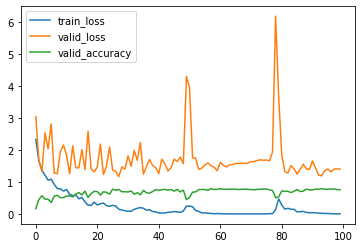

In [24]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random_seed = 15

In [25]:
random_seed = 15

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = GTZAN(data = data, labels = labels, keys = train_keys)
valid_dataset = GTZAN(data = data, labels = labels, keys = valid_keys)
test_dataset = GTZAN(data = data, labels = labels, keys = test_keys)

## Resnet50

#### No augmentation

setting everything to seed 15


100%|██████████| 100/100 [28:44<00:00, 17.25s/it]


Accuracy on the validation:  0.78125
************************
Quality of the model
Accuracy on test: 0.755


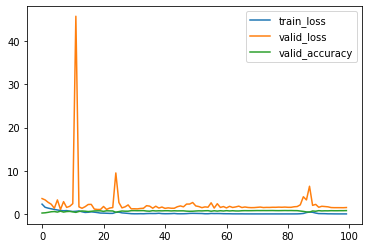

In [26]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

setting everything to seed 15


100%|██████████| 100/100 [29:07<00:00, 17.48s/it]


Accuracy on the validation:  0.775
************************
Quality of the model
Accuracy on test: 0.725


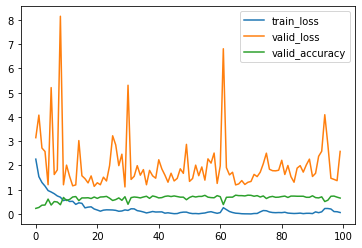

In [27]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random_seed = 23

In [28]:
random_seed = 23

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = GTZAN(data = data, labels = labels, keys = train_keys)
valid_dataset = GTZAN(data = data, labels = labels, keys = valid_keys)
test_dataset = GTZAN(data = data, labels = labels, keys = test_keys)

## Resnet50

#### No augmentation

setting everything to seed 23


100%|██████████| 100/100 [28:45<00:00, 17.25s/it]


Accuracy on the validation:  0.78125
************************
Quality of the model
Accuracy on test: 0.7


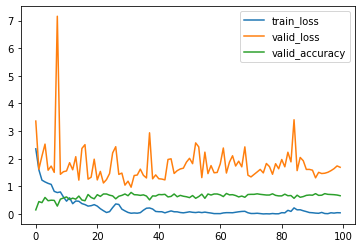

In [29]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

setting everything to seed 23


100%|██████████| 100/100 [29:08<00:00, 17.48s/it]


Accuracy on the validation:  0.7625
************************
Quality of the model
Accuracy on test: 0.73


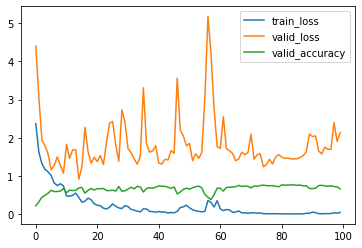

In [30]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Results

In [31]:
print("resnet50")
no_augmentation_accuracy50 = np.array(no_augmentation_accuracy50) * 100
time_swap_augmentation_accuracy50 = np.array(time_swap_augmentation_accuracy50) * 100
print("No augmentation")
print("mean:", np.mean(no_augmentation_accuracy50))
print("std:", np.std(no_augmentation_accuracy50))
print("TimeSwapAugmentation")
print("mean:", np.mean(time_swap_augmentation_accuracy50))
print("std:", np.std(time_swap_augmentation_accuracy50))

resnet50
No augmentation
mean: 73.0
std: 3.24037034920393
TimeSwapAugmentation
mean: 71.4
std: 4.913247398615299
